In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import stats
from scipy.stats import kstest,chi2
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1.1 Basic SIR Simulator (Clean)

In [2]:
def simulate_sir_simple(lam,mu,I_0,T):
    N = 1000
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)

    S[0] = N - I_0
    I[0] = I_0
    R[0] = 0

    dt =  1.0

    for t in range(T):
        dS_dt = -lam * S[t] * I[t] / N
        dI_dt = lam * S[t] * I[t] / N - mu * I[t]
        dR_dt = mu * I[t]
        S[t+1] = S[t] + dS_dt * dt
        I[t+1] = I[t] + dI_dt * dt
        R[t+1] = R[t] + dR_dt * dt

        S[t+1] = max(S[t+1], 0)
        I[t+1] = max(I[t+1], 0)
        R[t+1] = max(R[t+1], 0)

    Delta_S = S[1:] - S[:-1]

    Delta_R = R[1:] - R[:-1]

    X = np.column_stack([Delta_S, Delta_R])

    C = np.column_stack((S,I,R))
    return X, C


lam_test = 0.5
mu_test = 0.2
I_0_test = 10
T_test = 100

X_test, C_test = simulate_sir_simple(lam_test, mu_test, I_0_test, T_test)
print(f"Observations shape: {X_test.shape}")
print(f"ODE variables shape: {C_test.shape}")
print(f"Sample observations (first 5 days): \n{X_test[:5]}")

Observations shape: (100, 2)
ODE variables shape: (101, 3)
Sample observations (first 5 days): 
[[ -4.95         2.        ]
 [ -6.37819875   2.59      ]
 [ -8.19060156   3.34763975]
 [-10.4720553    4.31623211]
 [-13.31387902   5.54739675]]


## 1.2 Noisy SIR Simulator (Extended)

In [3]:
def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T):


    X_clean, C = simulate_sir_simple(lam, mu, I_0, T)
    
    X_noisy = np.zeros_like(X_clean)
    

    L = int(L) 
    for t in range(T):
        
        t_delayed = t - L
        
        if t_delayed < 0:
            
            X_noisy[t, 0] = 0
            X_noisy[t, 1] = 0
            continue 
        
        d_S = X_clean[t_delayed, 0]
        d_R = X_clean[t_delayed, 1]
        
        while True:
            epsilon_S = np.random.normal(rho, np.sqrt(sigma_2))
            if epsilon_S > 0: break
        
        while True:
            epsilon_R = np.random.normal(rho, np.sqrt(sigma_2))
            if epsilon_R > 0: break
            
        
        X_noisy[t, 0] = d_S * epsilon_S
        X_noisy[t, 1] = d_R * epsilon_R
        
    return X_noisy, C 

## 1.3 Visualize Noise Effect

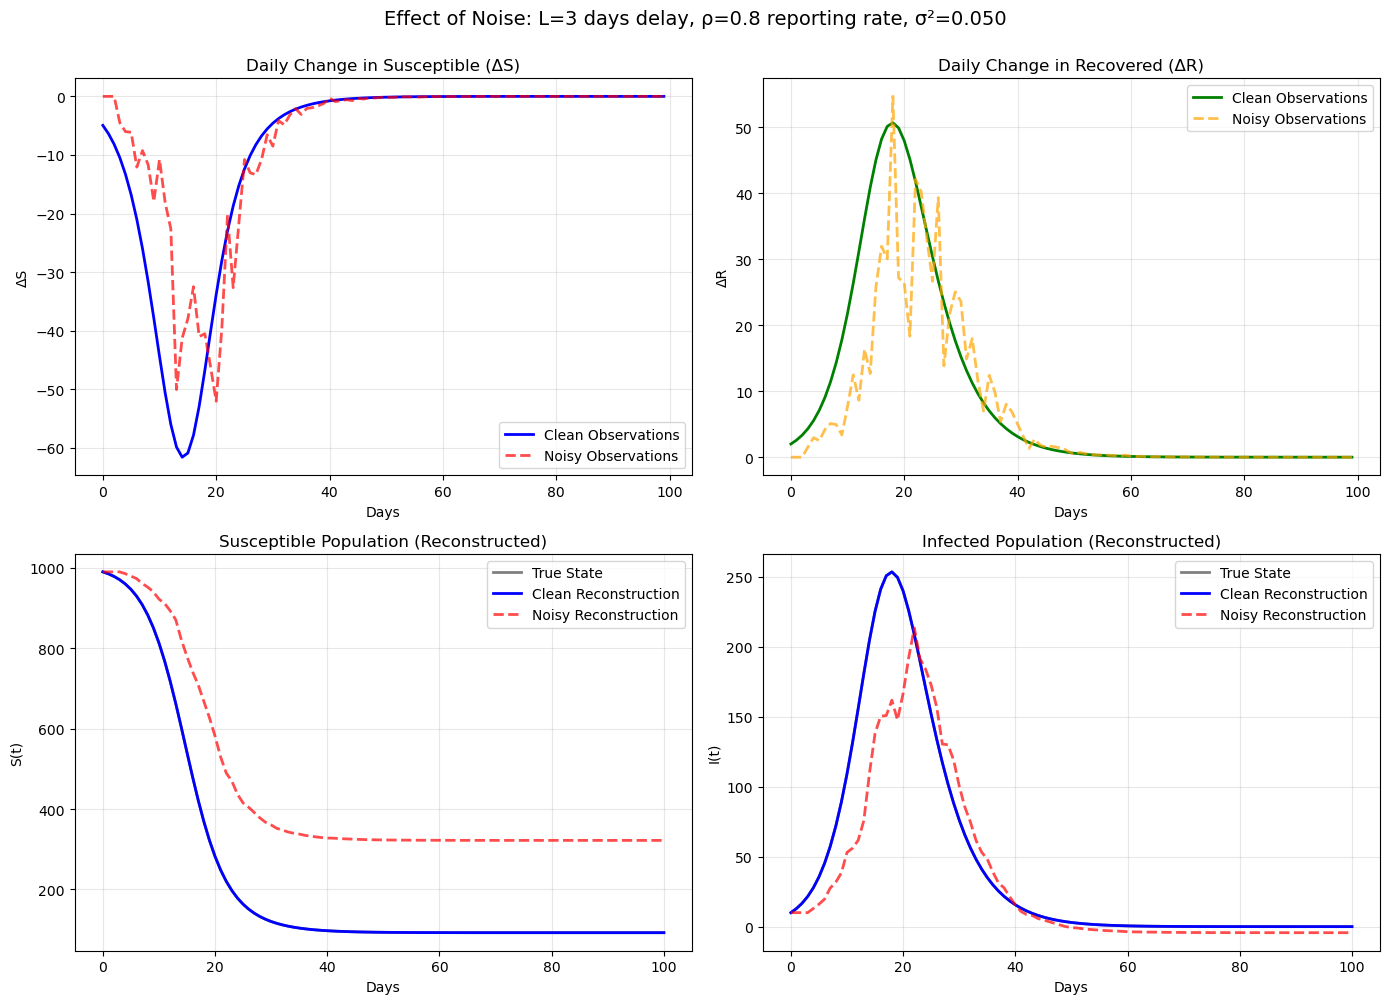

In [4]:
def visualize_noise_effect():
    lam, mu, I_0 = 0.5, 0.2, 10
    L, rho, sigma_2 = 3, 0.8, 0.05
    
    X_clean, C_clean = simulate_sir_simple(lam, mu, I_0, T=100)
    X_noisy, C_true = simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T=100)
    
    # Reconstruct states from noisy observations (what we would infer from data)
    N = 1000
    S_reconstructed = np.zeros(101)
    R_reconstructed = np.zeros(101)
    S_reconstructed[0] = N - I_0
    R_reconstructed[0] = 0
    
    for t in range(100):
        S_reconstructed[t+1] = S_reconstructed[t] + X_noisy[t, 0]
        R_reconstructed[t+1] = R_reconstructed[t] + X_noisy[t, 1]
    
    I_reconstructed = N - S_reconstructed - R_reconstructed
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    time = np.arange(100)
    time_states = np.arange(101)
    
    # ΔS comparison
    axes[0, 0].plot(time, X_clean[:, 0], 'b-', label='Clean Observations', linewidth=2)
    axes[0, 0].plot(time, X_noisy[:, 0], 'r--', label='Noisy Observations', alpha=0.7, linewidth=2)
    axes[0, 0].set_title('Daily Change in Susceptible (ΔS)', fontsize=12)
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('ΔS')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # ΔR comparison
    axes[0, 1].plot(time, X_clean[:, 1], 'g-', label='Clean Observations', linewidth=2)
    axes[0, 1].plot(time, X_noisy[:, 1], 'orange', linestyle='--', label='Noisy Observations', alpha=0.7, linewidth=2)
    axes[0, 1].set_title('Daily Change in Recovered (ΔR)', fontsize=12)
    axes[0, 1].set_xlabel('Days')
    axes[0, 1].set_ylabel('ΔR')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # S(t) comparison: True vs Reconstructed from noisy observations
    axes[1, 0].plot(time_states, C_true[:, 0], 'k-', label='True State', linewidth=2, alpha=0.5)
    axes[1, 0].plot(time_states, C_clean[:, 0], 'b-', label='Clean Reconstruction', linewidth=2)
    axes[1, 0].plot(time_states, S_reconstructed, 'r--', label='Noisy Reconstruction', alpha=0.7, linewidth=2)
    axes[1, 0].set_title('Susceptible Population (Reconstructed)', fontsize=12)
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('S(t)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # I(t) comparison: True vs Reconstructed from noisy observations
    axes[1, 1].plot(time_states, C_true[:, 1], 'k-', label='True State', linewidth=2, alpha=0.5)
    axes[1, 1].plot(time_states, C_clean[:, 1], 'b-', label='Clean Reconstruction', linewidth=2)
    axes[1, 1].plot(time_states, I_reconstructed, 'r--', label='Noisy Reconstruction', alpha=0.7, linewidth=2)
    axes[1, 1].set_title('Infected Population (Reconstructed)', fontsize=12)
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('I(t)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Effect of Noise: L={L} days delay, ρ={rho} reporting rate, σ²={sigma_2:.3f}', 
                 fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

visualize_noise_effect()

## 1.4 Prior Distributions

In [5]:
# Extend prior to include noise parameters
def sample_prior_noisy(n_samples):
    lam = np.random.uniform(0.3, 0.8, n_samples)
    mu = np.random.uniform(0.1, 0.4, n_samples)
    I_0 = np.random.uniform(5, 30, n_samples)
    
    # Noise parameters
    L = np.random.randint(0, 8, n_samples)  # delay: 0-7 days
    rho = np.random.uniform(0.5, 1.0, n_samples)  # underreporting: 50%-100%
    sigma_2 = np.random.uniform(0.01, 0.2, n_samples)  # error variance
    
    Y = np.column_stack([lam, mu, I_0, L, rho, sigma_2])
    return Y

def sample_prior_simple(n_samples):
    
    lam = np.random.uniform(0.3, 0.8, n_samples)
    mu = np.random.uniform(0.1, 0.4, n_samples)
    I_0 = np.random.uniform(5, 30, n_samples)
    return np.column_stack([lam, mu, I_0])


Y_noisy_prior = sample_prior_noisy(1000)
print(f"Extended prior samples shape: {Y_noisy_prior.shape}")
print(f"Parameter ranges:")
print(f"  λ: [{Y_noisy_prior[:, 0].min():.3f}, {Y_noisy_prior[:, 0].max():.3f}]")
print(f"  μ: [{Y_noisy_prior[:, 1].min():.3f}, {Y_noisy_prior[:, 1].max():.3f}]")
print(f"  I₀: [{Y_noisy_prior[:, 2].min():.1f}, {Y_noisy_prior[:, 2].max():.1f}]")
print(f"  L: [{Y_noisy_prior[:, 3].min():.0f}, {Y_noisy_prior[:, 3].max():.0f}]")
print(f"  ρ: [{Y_noisy_prior[:, 4].min():.3f}, {Y_noisy_prior[:, 4].max():.3f}]")
print(f"  σ²: [{Y_noisy_prior[:, 5].min():.3f}, {Y_noisy_prior[:, 5].max():.3f}]")

Extended prior samples shape: (1000, 6)
Parameter ranges:
  λ: [0.302, 0.800]
  μ: [0.101, 0.400]
  I₀: [5.0, 29.9]
  L: [0, 7]
  ρ: [0.500, 0.999]
  σ²: [0.010, 0.200]


## 2.1 Data Generation Functions

In [6]:
def generate_data_clean(n_samples, T=100):
    
    Y = sample_prior_simple(n_samples)  # (N, 3)
    X = []
    for i in range(n_samples):
        lam, mu, I_0 = Y[i]
        sim_x, _ = simulate_sir_simple(lam, mu, int(I_0), T)
        X.append(sim_x)
    return np.array(X), Y


def generate_data_noisy(n_samples, T=100):
    
    Y = sample_prior_noisy(n_samples)  # (N, 6)
    X = []
    for i in range(n_samples):
        lam, mu, I_0, L, rho, sigma_2 = Y[i]
        # I_0 and L must be interger
        sim_x, _ = simulate_sir_noisy(lam, mu, int(I_0), int(L), rho, sigma_2, T)
        X.append(sim_x)
    return np.array(X), Y

# Clean Model 
n_train = 5000
n_val = 1000
n_test = 200

print("=== Generating CLEAN Data ===")
X_train, Y_train = generate_data_clean(n_train, T=100)
X_val, Y_val = generate_data_clean(n_val, T=100)
X_test, Y_test = generate_data_clean(n_test, T=100)

print(f"Clean training data: X={X_train.shape}, Y={Y_train.shape}")
print(f"Clean validation data: X={X_val.shape}, Y={Y_val.shape}")
print(f"Clean test data: X={X_test.shape}, Y={Y_test.shape}")


# Noisy Model 
n_train_noisy = 5000
n_val_noisy = 1000
n_test_noisy = 200

print("\n=== Generating NOISY Data ===")
X_train_noisy, Y_train_noisy = generate_data_noisy(n_train_noisy, T=100)
X_val_noisy, Y_val_noisy = generate_data_noisy(n_val_noisy, T=100)
X_test_noisy, Y_test_noisy = generate_data_noisy(n_test_noisy, T=100)

print(f"Noisy training data: X={X_train_noisy.shape}, Y={Y_train_noisy.shape}")
print(f"Noisy validation data: X={X_val_noisy.shape}, Y={Y_val_noisy.shape}")
print(f"Noisy test data: X={X_test_noisy.shape}, Y={Y_test_noisy.shape}")



=== Generating CLEAN Data ===
Clean training data: X=(5000, 100, 2), Y=(5000, 3)
Clean validation data: X=(1000, 100, 2), Y=(1000, 3)
Clean test data: X=(200, 100, 2), Y=(200, 3)

=== Generating NOISY Data ===
Noisy training data: X=(5000, 100, 2), Y=(5000, 6)
Noisy validation data: X=(1000, 100, 2), Y=(1000, 6)
Noisy test data: X=(200, 100, 2), Y=(200, 6)


## 2.2 Data Normalization


In [7]:

print("\n=== Normalizing CLEAN Data ===")
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit on training data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler_X.fit(X_train_flat)
scaler_Y.fit(Y_train)

# Transform
X_train_norm = scaler_X.transform(X_train_flat)
X_val_norm = scaler_X.transform(X_val_flat)
X_test_norm = scaler_X.transform(X_test_flat)

Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)
Y_test_norm = scaler_Y.transform(Y_test)

print(f" Clean data normalized")
print(f"  Y_train mean: {Y_train_norm.mean(axis=0)}")
print(f"  Y_train std: {Y_train_norm.std(axis=0)}")



print("\n=== Normalizing NOISY Data ===")
scaler_X_noisy = StandardScaler()
scaler_Y_noisy = StandardScaler()

# Fit on training data
X_train_noisy_flat = X_train_noisy.reshape(X_train_noisy.shape[0], -1)
X_val_noisy_flat = X_val_noisy.reshape(X_val_noisy.shape[0], -1)
X_test_noisy_flat = X_test_noisy.reshape(X_test_noisy.shape[0], -1)

scaler_X_noisy.fit(X_train_noisy_flat)
scaler_Y_noisy.fit(Y_train_noisy)

# Transform
X_train_noisy_norm = scaler_X_noisy.transform(X_train_noisy_flat)
X_val_noisy_norm = scaler_X_noisy.transform(X_val_noisy_flat)
X_test_noisy_norm = scaler_X_noisy.transform(X_test_noisy_flat)

Y_train_noisy_norm = scaler_Y_noisy.transform(Y_train_noisy)
Y_val_noisy_norm = scaler_Y_noisy.transform(Y_val_noisy)
Y_test_noisy_norm = scaler_Y_noisy.transform(Y_test_noisy)

print(f" Noisy data normalized")
print(f"  Y_train_noisy mean: {Y_train_noisy_norm.mean(axis=0)}")
print(f"  Y_train_noisy std: {Y_train_noisy_norm.std(axis=0)}")



=== Normalizing CLEAN Data ===
 Clean data normalized
  Y_train mean: [ 1.56981761e-14 -9.04774033e-15  8.84607942e-15]
  Y_train std: [1. 1. 1.]

=== Normalizing NOISY Data ===
 Noisy data normalized
  Y_train_noisy mean: [-2.07998063e-15  1.83562054e-15  5.02305975e-15  2.66231481e-17
  3.30864225e-15 -5.51223511e-15]
  Y_train_noisy std: [1. 1. 1. 1. 1. 1.]


## 2.3 DataLoader Construction

In [8]:
class SIRDataset(Dataset):
    def __init__(self, X, Y):
        if X.ndim == 3:
            X = X.reshape(X.shape[0], -1)
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# Clean Model Loaders
train_dataset = SIRDataset(X_train_norm, Y_train_norm)
val_dataset = SIRDataset(X_val_norm, Y_val_norm)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print(f"\n Clean Model DataLoaders ready")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


# Noisy Model Loaders
train_dataset_noisy = SIRDataset(X_train_noisy_norm, Y_train_noisy_norm)
val_dataset_noisy = SIRDataset(X_val_noisy_norm, Y_val_noisy_norm)
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=128, shuffle=True)
val_loader_noisy = DataLoader(val_dataset_noisy, batch_size=128, shuffle=False)

print(f"\n Noisy Model DataLoaders ready")
print(f"  Training batches: {len(train_loader_noisy)}")
print(f"  Validation batches: {len(val_loader_noisy)}")



 Clean Model DataLoaders ready
  Training batches: 40
  Validation batches: 8

 Noisy Model DataLoaders ready
  Training batches: 40
  Validation batches: 8


## 3.1 Coupling Layer

In [9]:
class CouplingLayer(nn.Module):

    def __init__(self, input_dim, hidden_dim, condition_dim, mask):
        super(CouplingLayer, self).__init__()
        self.mask = mask
        

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  
        )
        
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )



    def forward(self, y, x, reverse = False):
        y_masked = y * self.mask

        s_input = torch.cat([y_masked, x], dim=1)
        t_input = torch.cat([y_masked, x], dim=1)

        s = self.scale_net(s_input) * (1 - self.mask)
        t = self.translate_net(t_input) * (1 - self.mask)

        if not reverse:
            output = y_masked + (1 - self.mask) * (y * torch.exp(s) + t)
            log_det = s.sum(dim=1)

        else:
            output = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
            log_det = -s.sum(dim=1)

        return output, log_det
        

## 3.2 Conditional RealNVP

In [10]:


class ConditionalRealNVP(nn.Module):
    def __init__(self, param_dim, condition_dim, hidden_dim=128, n_layers=6):
        super(ConditionalRealNVP, self).__init__()
        
        self.param_dim = param_dim
        self.condition_dim = condition_dim
    
        self.summary_net = nn.Sequential(
            nn.Linear(condition_dim, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32)
        )
        
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            mask = torch.zeros(param_dim)
            mask[:(param_dim // 2) if i % 2 == 0 else (param_dim // 2 + 1)] = 1
            self.layers.append(
                CouplingLayer(param_dim, hidden_dim, 32, mask)
            )
            
    
    def forward(self, y, x):
        
        h_x = self.summary_net(x)
        
        z = y
        log_det_sum = 0
        for layer in self.layers:
            z, log_det = layer(z, h_x, reverse=False)
            log_det_sum += log_det
        
        log_prob_base = -0.5 * (z ** 2).sum(dim=1) - 0.5 * self.param_dim * np.log(2 * np.pi)
        
        log_prob = log_prob_base + log_det_sum
        return log_prob
    
    def sample(self, x, n_samples=1):
        
        h_x = self.summary_net(x)
        

        if n_samples > 1:
            h_x = h_x.unsqueeze(1).repeat(1, n_samples, 1)
            h_x = h_x.reshape(-1, h_x.shape[-1])
        
        batch_size = x.shape[0]
        total_samples = batch_size * n_samples
        
        
        z = torch.randn(total_samples, self.param_dim, device=x.device)
        
        y = z
        for layer in reversed(self.layers):
            y,_ = layer(y,h_x,reverse=True)
        if n_samples > 1:
            y = y.reshape(batch_size,n_samples,self.param_dim)

        return y
    


## 3.3 Model Initialization

In [11]:

# Initialize conditional RealNVP Clean Model (3 parameters)
input_dim = 100 * 2
param_dim_clean = 3

flow_model = ConditionalRealNVP(
    param_dim=param_dim_clean,
    condition_dim=input_dim,
    hidden_dim=64,
    n_layers=4
).to(device)

print(f"\n=== Clean Model (3 parameters) ===")
print(f"Total parameters: {sum(p.numel() for p in flow_model.parameters()):,}")


# Noisy Model (6 parameters)
param_dim_noisy = 6

flow_model_noisy = ConditionalRealNVP(
    param_dim=param_dim_noisy,
    condition_dim=input_dim,
    hidden_dim=64,
    n_layers=5
).to(device)

print(f"\n=== Noisy Model (6 parameters) ===")
print(f"Total parameters: {sum(p.numel() for p in flow_model_noisy.parameters()):,}")



=== Clean Model (3 parameters) ===
Total parameters: 89,336

=== Noisy Model (6 parameters) ===
Total parameters: 106,524


# TASK 1: Clean Model Validation

In [12]:

def train_flow(model,train_loader,val_loader,n_epochs=20,lr=5e-4):
    # add weight_decay 正则化来防止过拟合
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=1e-5)
    #adjust learning rate based on validation loss（）
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=10)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            #add noise
            noise = torch.randn_like(Y_batch) * 0.05
            Y_batch_noisy = Y_batch + noise

            optimizer.zero_grad()
            log_prob = model(Y_batch, X_batch)
            loss = -log_prob.mean()
            loss.backward()
            #prevent exploding gradients（）
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                log_prob = model(Y_batch, X_batch)

                loss = -log_prob.mean()
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    return train_losses, val_losses




## 4.2 Train Clean Model


=== Training Clean Model ===
Epoch 5/30 - Train Loss: 0.030261, Val Loss: -0.128694
Epoch 10/30 - Train Loss: -0.456470, Val Loss: -0.236323
Epoch 15/30 - Train Loss: -0.665593, Val Loss: -0.678514
Epoch 20/30 - Train Loss: -0.732555, Val Loss: -0.828650
Epoch 25/30 - Train Loss: -0.718088, Val Loss: -0.947723
Epoch 30/30 - Train Loss: -0.933537, Val Loss: -0.843876


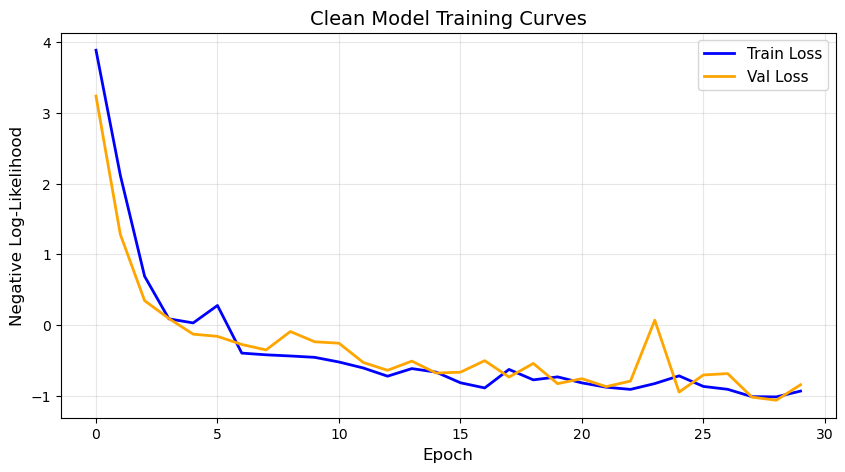


Final Training Loss:   -0.9335
Final Validation Loss: -0.8439


In [13]:
print("\n=== Training Clean Model ===")
flow_train_losses, flow_val_losses = train_flow(
    flow_model, train_loader, val_loader, n_epochs=30, lr=5e-4
)
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(flow_train_losses, label='Train Loss', linewidth=2, color='blue')
plt.plot(flow_val_losses, label='Val Loss', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log-Likelihood', fontsize=12)
plt.title('Clean Model Training Curves', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Training Loss:   {flow_train_losses[-1]:.4f}")
print(f"Final Validation Loss: {flow_val_losses[-1]:.4f}")


## 4.3 Wrapper Construction

In [14]:

class FlowWrapper:
    def __init__(self, flow_model, scaler_X, scaler_Y):
        self.flow = flow_model
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.device = next(flow_model.parameters()).device

    def _preprocess(self, X_raw):

        if isinstance(X_raw, np.ndarray):
            X_raw = torch.FloatTensor(X_raw)
            
        if X_raw.dim() == 3:
            N = X_raw.shape[0]
            X_flat = X_raw.reshape(N, -1)
        else:
            X_flat = X_raw
            
        X_flat_np = X_flat.cpu().numpy()
        X_norm_np = self.scaler_X.transform(X_flat_np)
        return torch.FloatTensor(X_norm_np).to(self.device)

    def sample_posterior(self, X_raw, n_samples=1000):
    
        X_tensor = self._preprocess(X_raw)
        
        self.flow.eval()
        with torch.no_grad():
            samples_norm = self.flow.sample(X_tensor, n_samples=n_samples).cpu().numpy()
            
        # unnormalize Y
        N, n_s, dim = samples_norm.shape
        flat_norm = samples_norm.reshape(-1, dim)
        flat_real = self.scaler_Y.inverse_transform(flat_norm)
        
        return flat_real.reshape(N, n_s, dim)

    def get_summary_norm(self, X_raw):
        X_tensor = self._preprocess(X_raw)
        self.flow.eval()
        with torch.no_grad():
            summary = self.flow.summary_net(X_tensor)
        return summary.cpu().numpy()


    def get_z_score(self, X_raw, Y_raw):
        
        #normalize X and Y
        X_tensor = self._preprocess(X_raw)
        
        Y_norm = self.scaler_Y.transform(Y_raw)
        Y_tensor = torch.FloatTensor(Y_norm).to(self.device)
    
        self.flow.eval()
        with torch.no_grad():
            
            h_x = self.flow.summary_net(X_tensor)
            z = Y_tensor
            for layer in self.flow.layers:
                z, _ = layer(z, h_x, reverse=False)
        
        return z.cpu().numpy()
    

    def log_posterior(self, Y_raw, X_raw):
    
        X_tensor = self._preprocess(X_raw)
        
        # Normalize Y
        Y_norm = self.scaler_Y.transform(Y_raw)
        Y_tensor = torch.FloatTensor(Y_norm).to(self.device)
        
        self.flow.eval()
        with torch.no_grad():
            log_prob = self.flow(Y_tensor, X_tensor)
        
        return log_prob.cpu().numpy()




In [15]:
wrapper_flow = FlowWrapper(flow_model, scaler_X, scaler_Y)
# Noisy wrapper will be constructed after training, using the same noisy scalers
wrapper_flow_noisy = None
print("\n Clean wrapper ready; noisy wrapper will be set after training")


 Clean wrapper ready; noisy wrapper will be set after training


##  Task 1 Validation

In [16]:

def compute_calibration(posterior_samples,true_values,confidence_levels=[0.5,0.68,0.95]):
    n_test,n_samples,param_dim = posterior_samples.shape
    results = {}

    for conf in confidence_levels:
        lower = (1-conf)/2
        upper = 1 -lower
        coverage = np.zeros(param_dim)

        for i in range(param_dim):
            # Compute credible intervals
            lower_bounds = np.quantile(posterior_samples[:,:,i],lower,axis=1)
            upper_bounds = np.quantile(posterior_samples[:,:,i],upper,axis=1)

            in_interval = (true_values[:,i] >= lower_bounds) & (true_values[:,i] <= upper_bounds)
            coverage[i] = in_interval.mean()

        results[conf] = coverage
    return results
 

def plot_validation_diagnostics(wrapper, X_test, theta_test, param_names):
    n_test = X_test.shape[0]
    n_samples = 1000 
    
    #Part 1: Marginal Calibration
    print(f"Sampling posterior for {n_test} test instances...")
    post_samples = wrapper.sample_posterior(X_test, n_samples)
    
    n_params = len(param_names)
    fig, axes = plt.subplots(2, n_params, figsize=(5 * n_params, 9))
    if n_params == 1: axes = np.expand_dims(axes, axis=1)

    for i, name in enumerate(param_names):
        #  Rank Histograms
        ranks = np.sum(post_samples[:, :, i] < theta_test[:, i:i+1], axis=1)
        pit_values = ranks / n_samples
        
        ax_hist = axes[0, i]
        ax_hist.hist(pit_values, bins=20, density=True, alpha=0.7, edgecolor='k', color='skyblue')
        ax_hist.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Ideal Uniform')
        ax_hist.set_title(f'Rank Hist: {name}')
        ax_hist.set_xlabel('PIT Value')
        if i == 0: ax_hist.set_ylabel('Density')
        
        #  ECDF
        ax_ecdf = axes[1, i]
        pit_sorted = np.sort(pit_values)
        y_vals = np.arange(1, n_test + 1) / n_test
        ax_ecdf.plot(pit_sorted, y_vals, drawstyle='steps-post', linewidth=2.5, label='Empirical')
        ax_ecdf.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal')
        ax_ecdf.set_title(f'ECDF: {name}')
        ax_ecdf.set_xlim([0, 1]); ax_ecdf.set_ylim([0, 1])
        ax_ecdf.grid(True, alpha=0.3)
        if i == 0: ax_ecdf.set_ylabel('Empirical CDF')

    plt.suptitle("Marginal Calibration Diagnostics", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # Part 2: Self-Consistency Check 
    print("\n[Running Self-Consistency Check - Prior Sampling Scheme]")
    
    
    log_probs_real = wrapper.log_posterior(theta_test, X_test)
    surprisals_real = -log_probs_real
    

    n_check = 500 
    surprisals_synthetic = []
    
    if len(param_names) == 3:
        params_prior = sample_prior_simple(n_check)
    else:
        params_prior = sample_prior_noisy(n_check)
    
    print(f"Generating synthetic data from {n_check} prior samples...")
    for i in tqdm(range(n_check)):
        params = params_prior[i]
        
        if len(param_names) == 3:
            lam, mu, I_0 = params
            X_sim, _ = simulate_sir_simple(
                np.clip(lam, 0, 5), np.clip(mu, 0, 2), int(np.clip(I_0, 1, 100)), T=100
            )
        else:
            lam, mu, I_0, L, rho, sigma_2 = params
            X_sim, _ = simulate_sir_noisy(
                np.clip(lam, 0, 5), np.clip(mu, 0, 2), int(np.clip(I_0, 1, 100)),
                int(np.clip(L, 0, 7)), np.clip(rho, 0.1, 1), np.clip(sigma_2, 0.001, 1), T=100
            )
            
        log_prob_sim = wrapper.log_posterior(params.reshape(1, -1), X_sim.reshape(1, -1))
        surprisals_synthetic.append(-log_prob_sim[0])

    surprisals_synthetic = np.array(surprisals_synthetic)

    


    fig, ax = plt.subplots(figsize=(10, 6))

    data_real = surprisals_real[np.isfinite(surprisals_real)]
    data_synth = surprisals_synthetic[np.isfinite(surprisals_synthetic)]
    
    if len(data_real) > 0 and len(data_synth) > 0:
        combined_range = np.concatenate([data_real, data_synth])
        bins = np.linspace(combined_range.min(), combined_range.max(), 40)
        
        ax.hist(data_synth, bins=bins, density=True, alpha=0.4, color='tab:blue', 
                edgecolor='none', label='Synthetic Data (Prior Samples)')
        ax.hist(data_real, bins=bins, density=True, histtype='step', linewidth=2.5, 
                color='black', label='Observed Data (Real)')
        
        ax.set_xlabel('Surprisal: $-\\log q(\\theta|x)$')
        ax.set_title('Self-Consistency Check (Prior Sampling)')
        ax.legend()
        
        print(f"Mean Real: {data_real.mean():.3f}, Mean Synth: {data_synth.mean():.3f}")

    plt.show()


def posterior_predictive_check(wrapper, X_test, Y_test, n_posterior_samples=100):

    n_test = len(X_test)
    

    Y_posterior_samples_real = wrapper.sample_posterior(X_test, n_samples=n_posterior_samples)
    
    
    C_true = []
    for i in range(n_test):
        lam, mu, I_0 = Y_test[i] 
        _, C = simulate_sir_simple(lam, mu, int(I_0), T=100)
        C_true.append(C)
    C_true = np.array(C_true)

   
    C_simulated = np.zeros((n_test, n_posterior_samples, 101, 3))

    for i in tqdm(range(n_test), desc="Running PPC"):
        for k in range(n_posterior_samples):
            
            lam, mu, I_0 = Y_posterior_samples_real[i, k]
            
        
            lam = np.clip(lam, 0.0, 5.0)
            mu  = np.clip(mu, 0.0, 2.0)
            I_0 = np.clip(I_0, 1.0, 100.0)
            
            try:
                _, C = simulate_sir_simple(lam, mu, int(I_0), T=100)
                C_simulated[i, k] = C
            except:
                C_simulated[i, k] = np.zeros((101, 3))
    
    return C_true, C_simulated


C_true_ppc, C_simulated_ppc = posterior_predictive_check(
    wrapper_flow, X_test[:20], Y_test[:20], n_posterior_samples=100
)

print(f"\nPosterior-predictive check completed:")
print(f"True outcomes shape: {C_true_ppc.shape}")
print(f"Simulated outcomes shape: {C_simulated_ppc.shape}")




Running PPC: 100%|██████████| 20/20 [00:00<00:00, 89.44it/s]


Posterior-predictive check completed:
True outcomes shape: (20, 101, 3)
Simulated outcomes shape: (20, 100, 101, 3)


TASK 1: CLEAN MODEL VALIDATION

--- 1.1 Marginal Calibration Results ---
50% CI Coverage: λ=0.360, μ=0.420, I₀=0.395 (Expected: 0.5)
68% CI Coverage: λ=0.570, μ=0.665, I₀=0.605 (Expected: 0.68)
95% CI Coverage: λ=1.000, μ=0.990, I₀=0.980 (Expected: 0.95)

--- 1.2 Visual Diagnostics ---
Sampling posterior for 100 test instances...


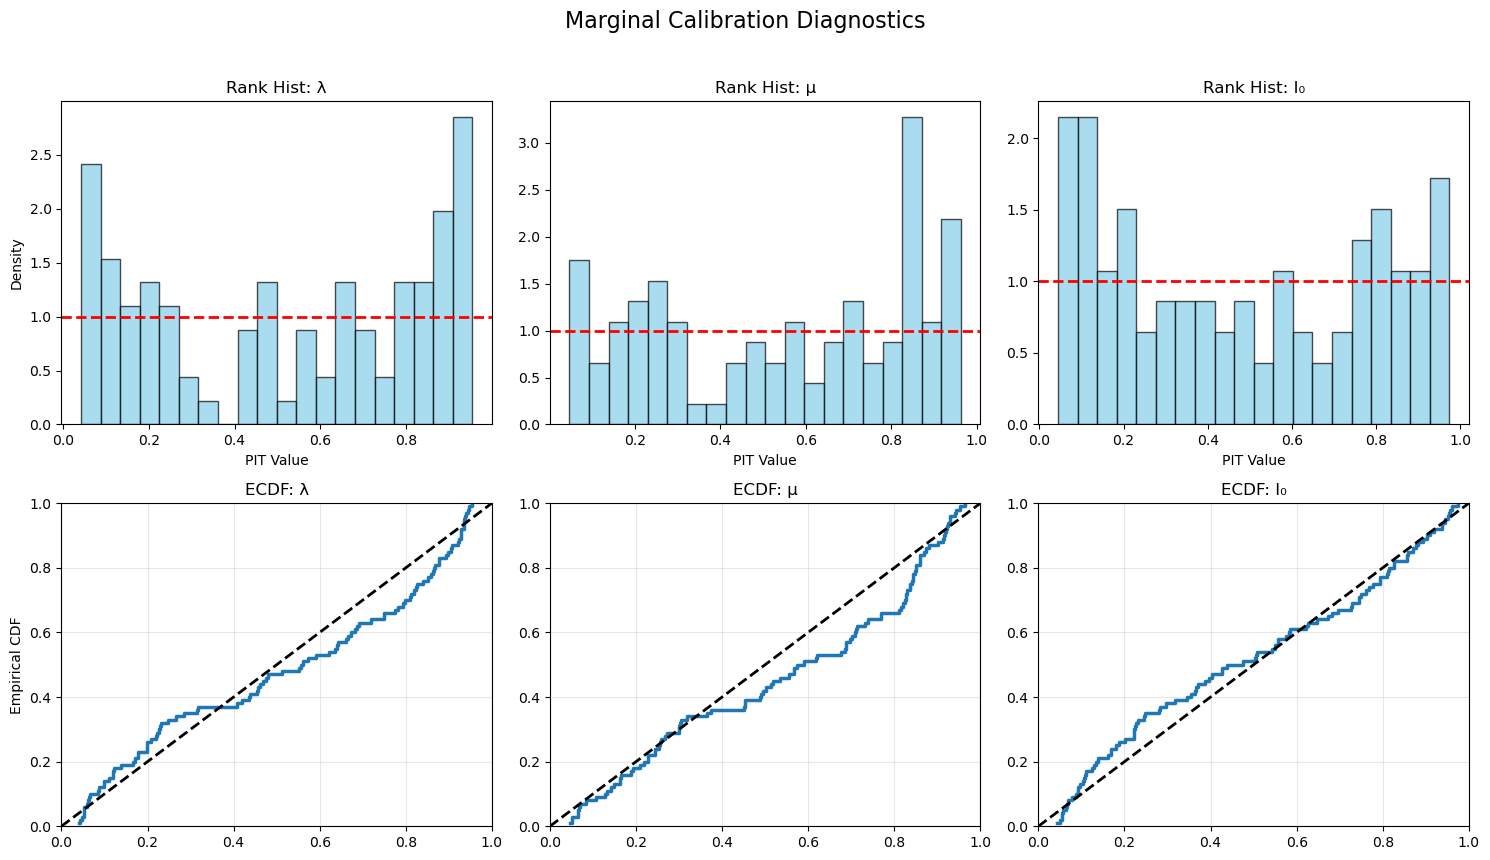


[Running Self-Consistency Check - Prior Sampling Scheme]
Generating synthetic data from 500 prior samples...


100%|██████████| 500/500 [00:00<00:00, 2195.24it/s]


Mean Real: -0.691, Mean Synth: -0.855


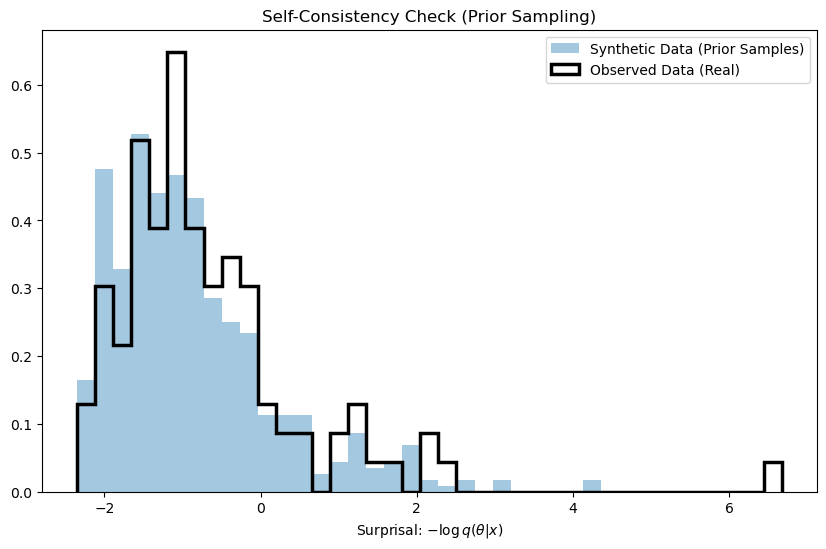


--- 1.3 Posterior Predictive Check ---


Running PPC: 100%|██████████| 4/4 [00:00<00:00, 91.43it/s]


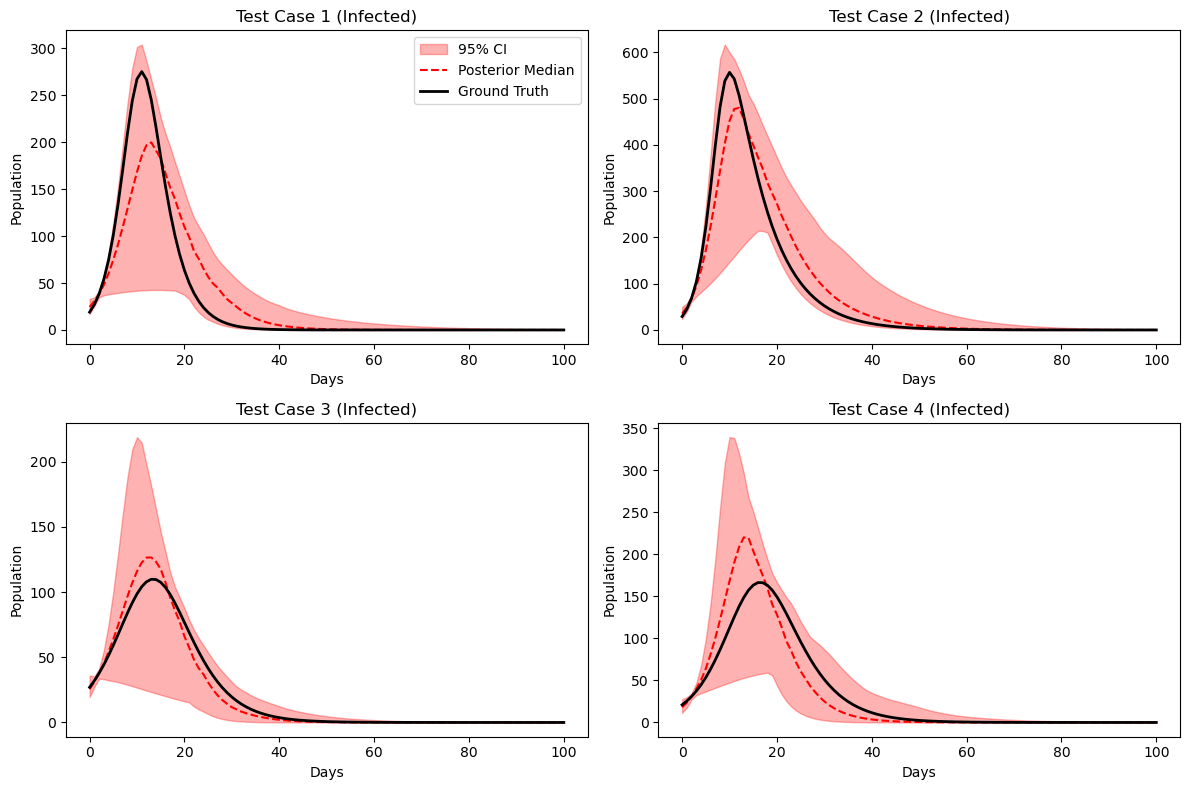

In [17]:

print("TASK 1: CLEAN MODEL VALIDATION")


X_test_clean, Y_test_clean = generate_data_clean(200)

# 1. Marginal Calibration
print("\n--- 1.1 Marginal Calibration Results ---")
post_samples_clean = wrapper_flow.sample_posterior(X_test_clean, n_samples=1000)
cal_results = compute_calibration(post_samples_clean, Y_test_clean)

for conf, cov in cal_results.items():
    print(f"{int(conf*100)}% CI Coverage: λ={cov[0]:.3f}, μ={cov[1]:.3f}, I₀={cov[2]:.3f} (Expected: {conf})")

# 2. Visual Diagnostics
print("\n--- 1.2 Visual Diagnostics ---")
plot_validation_diagnostics(wrapper_flow, X_test_clean[:100], Y_test_clean[:100], ['λ', 'μ', 'I₀'])

# 3. PPC
print("\n--- 1.3 Posterior Predictive Check ---")
C_true_ppc, C_sim_ppc = posterior_predictive_check(wrapper_flow, X_test_clean[:4], Y_test_clean[:4])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
time = np.arange(101)
for idx in range(4):
    ax = axes[idx]
    # Plotting Infected (I) compartment
    lower = np.percentile(C_sim_ppc[idx, :, :, 1], 2.5, axis=0)
    upper = np.percentile(C_sim_ppc[idx, :, :, 1], 97.5, axis=0)
    median = np.median(C_sim_ppc[idx, :, :, 1], axis=0)
    
    ax.fill_between(time, lower, upper, color='red', alpha=0.3, label='95% CI')
    ax.plot(time, median, 'r--', label='Posterior Median')
    ax.plot(time, C_true_ppc[idx, :, 1], 'k-', linewidth=2, label='Ground Truth')
    ax.set_title(f'Test Case {idx+1} (Infected)')
    ax.set_xlabel('Days')
    ax.set_ylabel('Population')
    if idx == 0: ax.legend()
plt.tight_layout()
plt.show()

# TASK 2: Inference on Noisy Data


=== Training Noisy Model ===
Epoch 5/40 - Train Loss: 6.018003, Val Loss: 5.949496
Epoch 10/40 - Train Loss: 5.529229, Val Loss: 5.585603
Epoch 15/40 - Train Loss: 5.239725, Val Loss: 5.558123
Epoch 20/40 - Train Loss: 5.036607, Val Loss: 5.451180
Epoch 25/40 - Train Loss: 4.941789, Val Loss: 5.283181
Epoch 30/40 - Train Loss: 4.774785, Val Loss: 5.452939
Epoch 35/40 - Train Loss: 4.589562, Val Loss: 5.322792
Epoch 40/40 - Train Loss: 4.319953, Val Loss: 5.559283


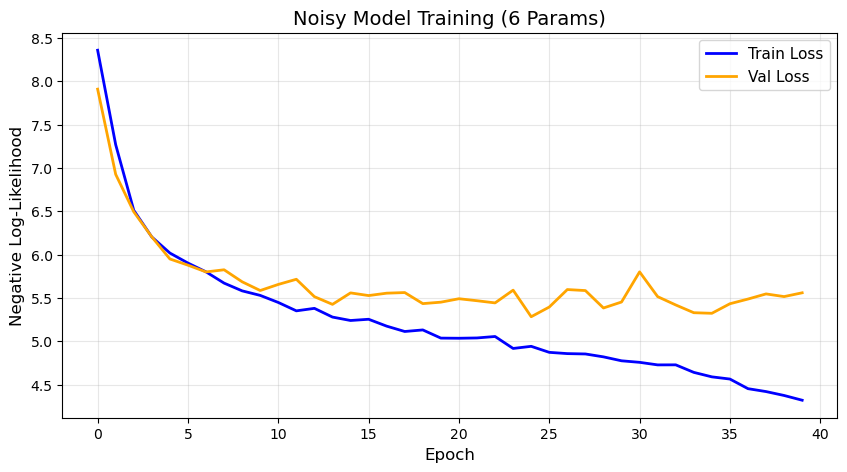

 Noisy Wrapper ready (reusing pre-fit noisy scalers)

--- Noisy Model Diagnostics ---
Sampling posterior for 100 test instances...


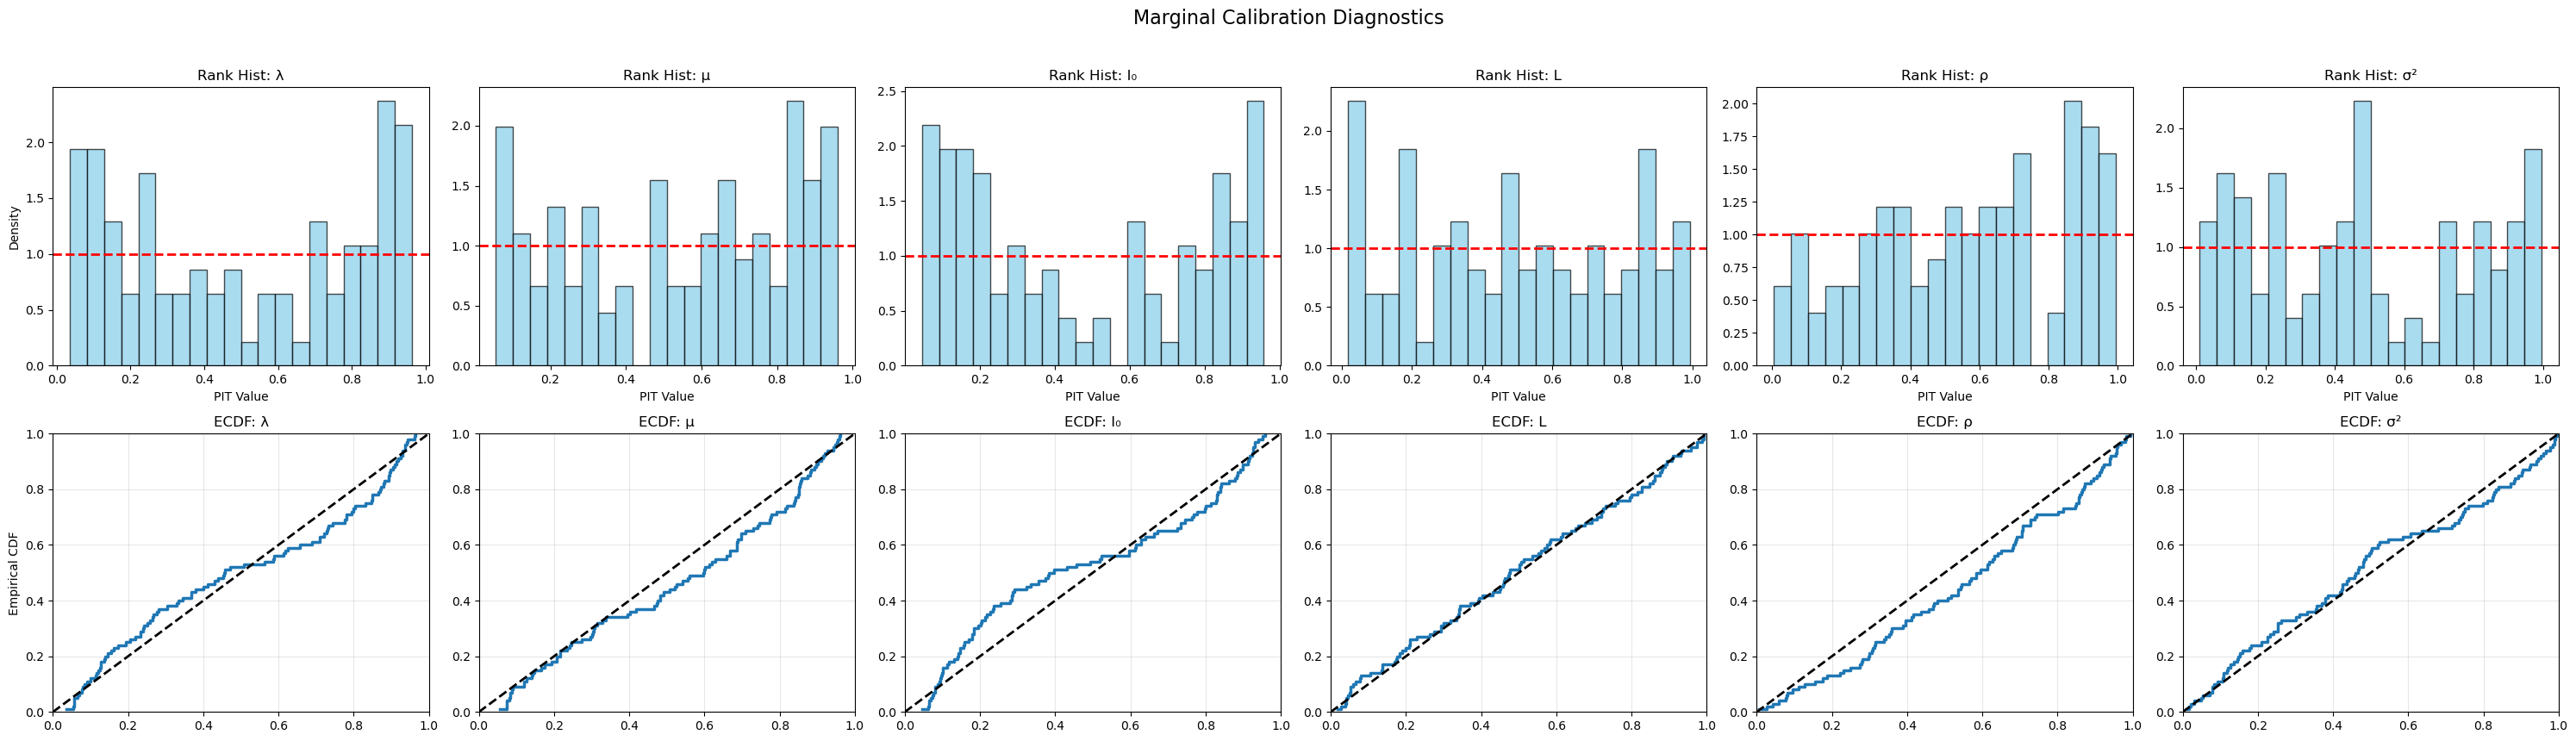


[Running Self-Consistency Check - Prior Sampling Scheme]
Generating synthetic data from 500 prior samples...


100%|██████████| 500/500 [00:00<00:00, 1541.91it/s]

Mean Real: 5.921, Mean Synth: 5.846


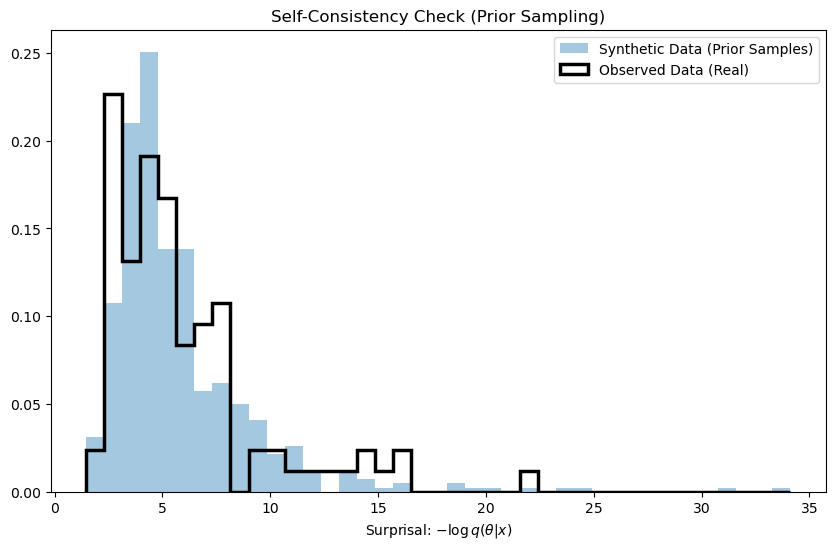

In [18]:

print("\n=== Training Noisy Model ===")
flow_train_losses_noisy, flow_val_losses_noisy = train_flow(
    flow_model_noisy, train_loader_noisy, val_loader_noisy, n_epochs=40, lr=5e-4
)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(flow_train_losses_noisy, label='Train Loss', linewidth=2, color='blue')
plt.plot(flow_val_losses_noisy, label='Val Loss', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log-Likelihood', fontsize=12)
plt.title('Noisy Model Training (6 Params)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()


wrapper_flow_noisy = FlowWrapper(flow_model_noisy, scaler_X_noisy, scaler_Y_noisy)
print(" Noisy Wrapper ready (reusing pre-fit noisy scalers)")


print("\n--- Noisy Model Diagnostics ---")
# Regenerate test data
X_test_noisy, Y_test_noisy = generate_data_noisy(200)

param_names_noisy = ['λ', 'μ', 'I₀', 'L', 'ρ', 'σ²']
plot_validation_diagnostics(
    wrapper_flow_noisy, 
    X_test_noisy[:100], 
    Y_test_noisy[:100], 
    param_names_noisy
)

# TASK 3: Model Misspecification Detection

In [ ]:
def detect_misspecification_z_space(wrapper_clean, X_raw, Y_raw=None):
    
    z = wrapper_clean.get_z_score(X_raw, Y_raw)
    
    n_samples, dim = z.shape
    
    # multi dimensions normality tests
    print("\n=== Per-Dimension Normality Tests ===")
    p_values = []
    for i in range(dim):
        stat, p_val = kstest(z[:, i], 'norm')
        p_values.append(p_val)
        param_name = ['λ', 'μ', 'I₀'][i] if dim == 3 else ['λ', 'μ', 'I₀', 'L', 'ρ', 'σ²'][i]
        print(f"  {param_name}: KS stat={stat:.4f}, p-value={p_val:.4e}")
    
    significance_level = 0.05 / dim
    n_rejected = sum(p < significance_level for p in p_values)
    
    print(f"\nBonferroni-corrected significance: {significance_level:.4f}")
    print(f"Rejected dimensions: {n_rejected}/{dim}")
    
    z_squared_norm = np.sum(z**2, axis=1)
    ks_stat, ks_p = kstest(z_squared_norm, chi2(dim).cdf)
    
    print(f"\n=== Chi-Square Test (||z||²) ===")
    print(f"KS stat: {ks_stat:.4f}, p-value: {ks_p:.4e}")
    print(f"  ||z||² range: [{z_squared_norm.min():.2f}, {z_squared_norm.max():.2f}]")
    print(f"  ||z||² mean: {z_squared_norm.mean():.2f} (expected: {dim})")
    
 
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Q-Q plot
    from scipy import stats as sp_stats
    ax = axes[0]
    sp_stats.probplot(z[:, 0], dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {["λ", "μ", "I₀"][0]} (z-space)')
    ax.grid(True, alpha=0.3)
    
    # Plot 2:  log scale
    ax = axes[1]
    
    empirical_max = z_squared_norm.max()
    theoretical_max = chi2.ppf(0.999, dim)
    x_max = max(empirical_max, theoretical_max) * 1.1
    
    bins = np.linspace(0, x_max, 50)
    ax.hist(z_squared_norm, bins=bins, density=True, alpha=0.6, 
            label='Empirical $||z||^2$', color='steelblue', edgecolor='black')
    
    x_grid = np.linspace(0, x_max, 500)
    ax.plot(x_grid, chi2.pdf(x_grid, dim), 'r--', linewidth=2.5, 
            label=f'$\\chi^2({dim})$')
    
    ax.set_xlabel('$||z||^2$')
    ax.set_ylabel('Density (log scale)')
    ax.set_yscale('log')  
    ax.set_title('Full Distribution (Log Scale)')
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')
    
    # Plot 3: main area
    ax = axes[2]
    
    theoretical_99 = chi2.ppf(0.99, dim)
    zoom_max = theoretical_99 * 1.5
    
    mask = z_squared_norm <= zoom_max
    if mask.sum() > 0:
        bins_zoom = np.linspace(0, zoom_max, 40)
        ax.hist(z_squared_norm[mask], bins=bins_zoom, density=True, alpha=0.6, 
                label=f'Empirical (n={mask.sum()})', color='steelblue', edgecolor='black')
    
    x_grid_zoom = np.linspace(0, zoom_max, 500)
    ax.plot(x_grid_zoom, chi2.pdf(x_grid_zoom, dim), 'r--', linewidth=2.5, 
            label=f'$\\chi^2({dim})$')
    

    coverage = (z_squared_norm <= theoretical_99).mean()
    ax.axvline(theoretical_99, color='green', linestyle=':', linewidth=2, 
               label=f'99% quantile\n({coverage*100:.1f}% covered)')
    
    ax.set_xlabel('$||z||^2$')
    ax.set_ylabel('Density')
    ax.set_title(f'Zoomed View (0 to {zoom_max:.1f})')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if ks_p < 0.01:
        print("\n STRONG evidence of model misspecification")
    elif ks_p < 0.05:
        print("\n  MODERATE evidence of model misspecification")
    else:
        print("\n Model appears well-specified")
    
    return ks_stat, ks_p, p_values

TASK 3: MODEL MISSPECIFICATION DETECTION

[TEST 1] Clean Model on Clean Data (Well-specified)

=== Per-Dimension Normality Tests ===
  λ: KS stat=0.1030, p-value=2.6719e-02
  μ: KS stat=0.4199, p-value=1.7605e-32
  I₀: KS stat=0.1617, p-value=4.8783e-05

Bonferroni-corrected significance: 0.0167
Rejected dimensions: 2/3

=== Chi-Square Test (||z||²) ===
KS stat: 0.1093, p-value: 1.5573e-02
  ||z||² range: [0.03, 11.23]
  ||z||² mean: 2.48 (expected: 3)


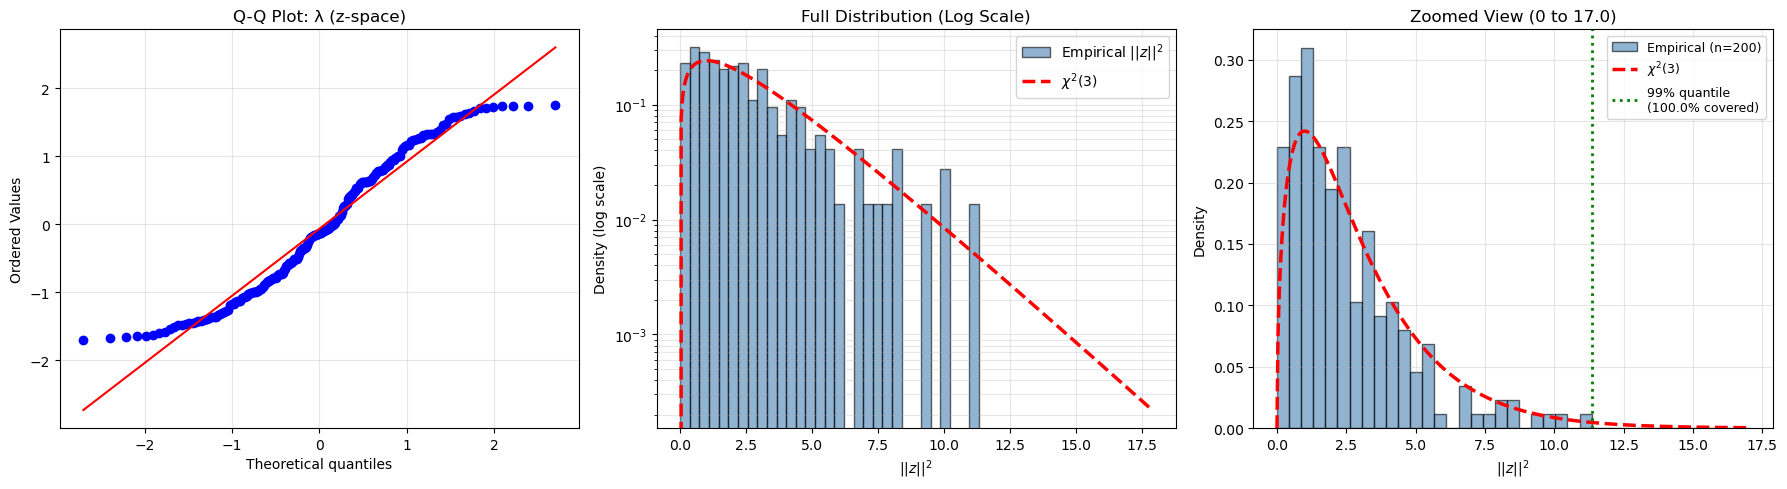


⚠️  MODERATE evidence of model misspecification

[TEST 2] Clean Model on Noisy Data (Misspecified)

=== Per-Dimension Normality Tests ===
  λ: KS stat=0.1203, p-value=1.0170e-01
  μ: KS stat=0.8100, p-value=8.8601e-72
  I₀: KS stat=0.8671, p-value=6.0018e-88

Bonferroni-corrected significance: 0.0167
Rejected dimensions: 2/3

=== Chi-Square Test (||z||²) ===
KS stat: 0.9796, p-value: 1.6488e-169
  ||z||² range: [2.89, 11543.37]
  ||z||² mean: 1440.89 (expected: 3)


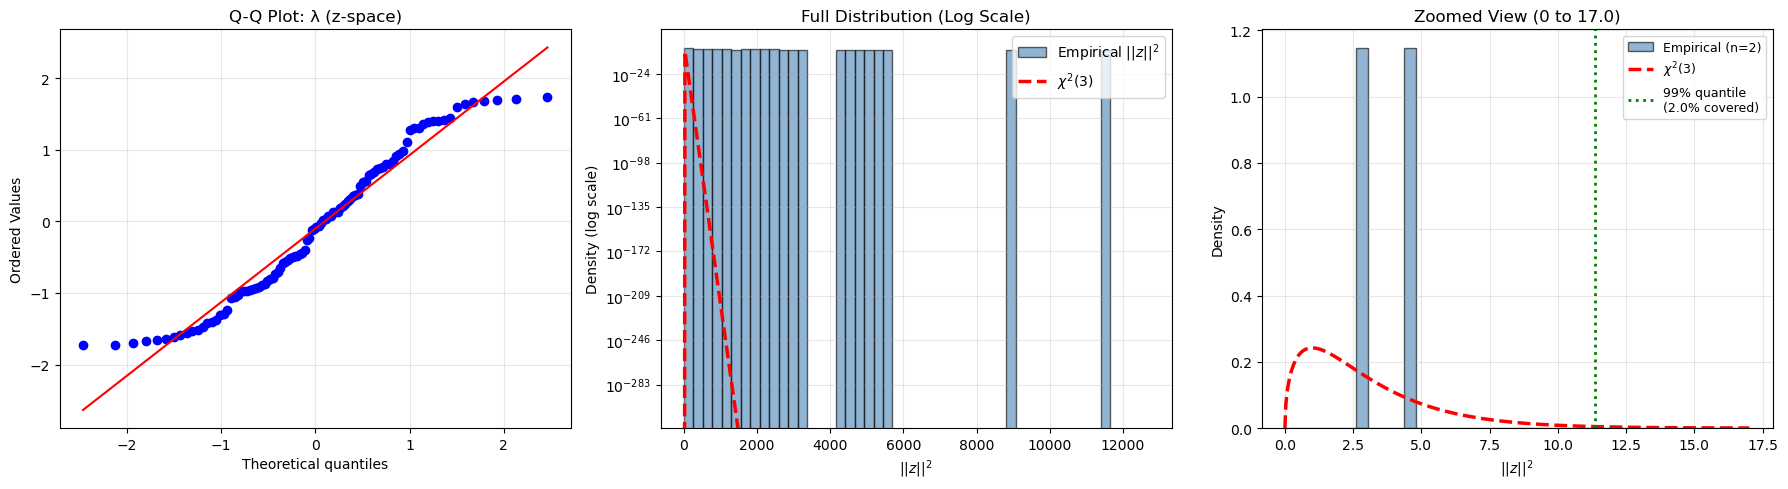


🚨 STRONG evidence of model misspecification


(0.9796220102933344,
 1.648784321548224e-169,
 [0.10170099710687042, 8.860124040874361e-72, 6.001812569424136e-88])

In [30]:
print("TASK 3: MODEL MISSPECIFICATION DETECTION")

# Test 1: Clean model on clean data (pass)
print("\n[TEST 1] Clean Model on Clean Data (Well-specified)")
X_clean_test, Y_clean_test = generate_data_clean(200)
detect_misspecification_z_space(wrapper_flow, X_clean_test, Y_clean_test)

# Test 2: Clean model on noisy data (fail)
print("\n[TEST 2] Clean Model on Noisy Data (Misspecified)")
X_noisy_test, Y_noisy_test = generate_data_noisy(200)
detect_misspecification_z_space(wrapper_flow, X_noisy_test[:100], Y_noisy_test[:100, :3])

